# Digital filter design using python

**Author** : Falak Shah


Based on [this excellent Matlab tutorial.](https://in.mathworks.com/help/signal/examples/practical-introduction-to-digital-filter-design.html) on the subject

The ideal lowpass filter is one that leaves unchanged all frequency components of a signal below a designated cutoff frequency, ωc
, and rejects all components above ωc
. Because the impulse response required to implement the ideal lowpass filter is infinitely long, it is impossible to design an ideal FIR lowpass filter. Finite length approximations to the ideal impulse response lead to the presence of ripples in both the passband (ω<ωc) and the stopband (ω>ωc) of the filter, as well as to a nonzero transition width between passband and stopband.

Both the passband/stopband ripples and the transition width are undesirable but unavoidable deviations from the response of an ideal lowpass filter when approximated with a finite impulse response. These deviations are depicted in the following figure:

![alt text](https://in.mathworks.com/help/examples/signal/win64/FilterDesignIntroductionExample_01.png)

Practical FIR designs typically consist of filters that have a transition width and maximum passband and stopband ripples that do not exceed allowable values. In addition to those design specifications, one must select the filter order,or, equivalently, the length of the truncated impulse response.

A useful metaphor for the design specifications in filter design is to think of each specification as one of the angles in the triangle shown in the figure below.

![DOF triangle](https://in.mathworks.com/help/examples/signal/win64/FilterDesignIntroductionExample_02.png)

The triangle is used to understand the degrees of freedom available when choosing design specifications. Because the sum of the angles is fixed, one can at most select the values of two of the specifications. The third specification will be determined by the particular design algorithm. Moreover, as with the angles in a triangle, if we make one of the specifications larger/smaller, it will impact one or both of the other specifications.

FIR filters are very attractive because they are inherently stable and can be designed to have linear phase. Nonetheless, these filters can have long transient responses and might prove computationally expensive in certain applications.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import *

**Minimum-Order FIR Designs**

Minimum-order designs are obtained by specifying passband and stopband frequencies as well as a passband ripple and a stopband attenuation. The design algorithm then chooses the minimum filter length that complies with the specifications.

Design a minimum-order lowpass FIR filter with a passband frequency of 0.37*pi rad/sample, a stopband frequency of 0.43*pi rad/sample (hence the transition width equals 0.06*pi rad/sample), a passband ripple of 1 dB and a stopband attenuation of 30 dB.

See the filtering functionalities available here: https://docs.scipy.org/doc/scipy/reference/signal.html

In [ ]:
fpass = 370 
fstop = 430
ap = 1
astop = 30
fs = 2000 

filtord = np.ceil(fs/(fstop-fpass) * (astop/22)).astype(np.int32)
# https://dsp.stackexchange.com/questions/37646/filter-order-rule-of-thumb?newreg=141e955c67704f9d8b5df855233101c1

In [ ]:
print('Order as computed using Fred Harris rule of thumb: {}'.format(filtord))

Order as computed using Fred Harris rule of thumb: 46


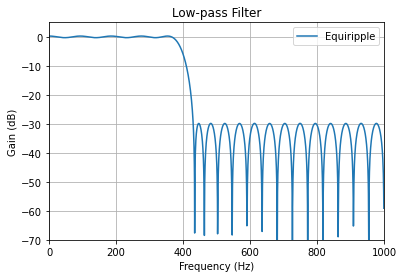

In [ ]:
def plot_response(fs, w, h, title="Low-pass Filter",label='', ax=None, ylim=-70):
    "Utility function to plot response functions"
    if not ax:
      fig = plt.figure()
      ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)), label=label)
    ax.set_ylim(ylim, 5)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)
    ax.legend()
    return ax
    
taps = remez(filtord, [0, fpass, fstop, 1000], [1, 0], fs = 2000)
w, h = freqz(taps, [1], worN=2000)
ax = plot_response(fs, w, h, label='Equiripple', title="Low-pass Filter")

The designfilt function chooses an equiripple design algorithm by default. Linear-phase equiripple filters are desirable because for a given order they have the smallest possible maximum deviation from the ideal filter.

Note, however, that minimum-order designs can also be obtained using a Kaiser window. Even though the Kaiser window method yields a larger filter order for the same specifications, the algorithm is less computationally expensive and less likely to have convergence issues when the design specifications are very stringent. This may occur if the application requires a very narrow transition width or a very large stopband attenuation.

Design a filter with the same specifications as above using the Kaiser window method and compare its response to the equiripple filter.

53


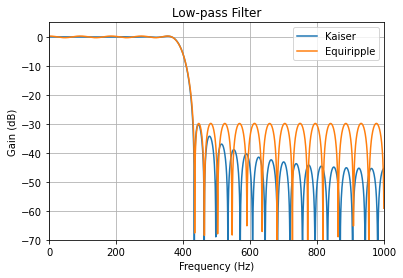

In [ ]:
fpass = 370
fstop = 430
astop = 30
apass = 1
fs = 2000
fc = fpass + (fstop-fpass)/2

filtord_kaiser, beta = kaiserord(astop, 2*(fstop-fpass)/fs)
print(filtord_kaiser)
taps = firwin(filtord_kaiser, fc, window=('kaiser', beta), 
              fs=fs)
w, h = freqz(taps, [1], worN=2000)
ax = plot_response(fs, w, h, label='Kaiser', title="Low-pass Filter")

taps = remez(filtord, [0, fpass, fstop, 1000], [1, 0], fs = 2000)
w, h = freqz(taps, [1], worN=2000)
plot_response(fs, w, h, label='Equiripple', title="Low-pass Filter", ax=ax)

Fixed Order, Fixed Transition Width

Fixed-order designs are useful for applications that are sensitive to computational load or impose a limit on the number of filter coefficients. An option is to fix the transition width at the expense of control over the passband ripple/stopband attenuation.

Consider a 30-th order lowpass FIR filter with a passband frequency of 370 Hz, a stopband frequency of 430 Hz, and sample rate of 2 kHz. There are two design methods available for this particular set of specifications: equiripple and least squares. Let us design one filter for each method and compare the results.

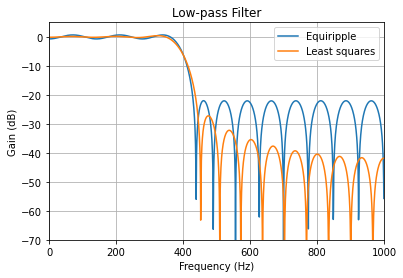

In [ ]:
fpass = 370;
fstop = 430;
fs = 2000;
N=30

taps = remez(N, [0, fpass, fstop, 1000], [1, 0], fs = 2000)
w, h = freqz(taps, [1], worN=2000)
ax = plot_response(fs, w, h, label='Equiripple', title="Low-pass Filter")

taps = firls(N+1, [0, fpass, fstop, 1000], [1,1,0, 0],  fs = 2000)
w, h = freqz(taps, [1], worN=2000)
plot_response(fs, w, h, title="Low-pass Filter",  label='Least squares',ax=ax)

Equiripple filters are ideally suited for applications in which a specific tolerance must be met, such as designing a filter with a given minimum stopband attenuation or a given maximum passband ripple. On the other hand, these designs may not be desirable if we want to minimize the energy of the error (between ideal and actual filter) in the passband/stopband.

If you want to reduce the energy of a signal as much as possible in a certain frequency band, use a least-squares design.

In the examples above, the designed filters had the same ripple in the passband and in the stopband. We can use weights to reduce the ripple in one of the bands while keeping the filter order fixed. For example, if you wish the stopband ripple to be a tenth of that in the passband, you must give the stopband ten times the passband weight. Redesign the equiripple filter using that fact.

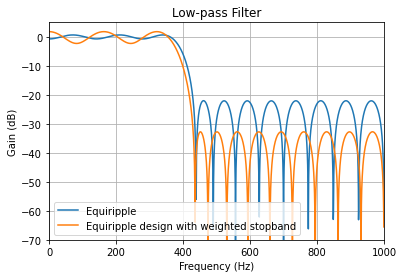

In [ ]:
N = 30;
fpass = 370;
fstop = 430;
fs = 2000;


taps = remez(N, [0, fpass, fstop, 1000], [1, 0], fs = 2000)
w, h = freqz(taps, [1], worN=2000)
ax = plot_response(fs, w, h, label='Equiripple', title="Low-pass Filter")

taps = remez(N, [0, fpass, fstop, 1000], [1, 0],[1, 10], fs = 2000)
w, h = freqz(taps, [1], worN=2000)
plot_response(fs, w, h, title="Low-pass Filter", label='Equiripple design with weighted stopband', ax=ax)

## Fixed Order, Fixed Cutoff Frequency

You can design filters with fixed filter order and cutoff frequency using a window design method.

You can use different windows to control the stopband attenuation while keeping the filter order unchanged.

For example, consider a 100-th order lowpass FIR filter with a cutoff frequency of 60 Hz and a sample rate of 1 kHz. Compare designs that result from using a Hamming window, and a Chebyshev window with 90 dB of sidelobe attenuation.

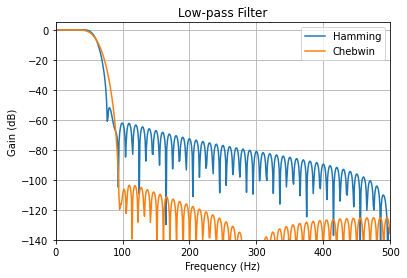

In [ ]:
N = 100
fc = 60
fs = 1000

taps = firwin(N, fc, window='hamming', 
              fs=fs)
w, h = freqz(taps)
ax = plot_response(fs, w, h, label='Hamming',ylim=-140, title="Low-pass Filter")

taps = firwin(N, fc, window=('chebwin', 90), 
              fs=fs)
w, h = freqz(taps)
plot_response(fs, w, h, label='Chebwin', ylim=-140,title="Low-pass Filter", ax=ax)

## IIR Filter Design

One of the drawbacks of FIR filters is that they require a large filter order to meet some design specifications. If the ripples are kept constant, the filter order grows inversely proportional to the transition width. By using feedback, it is possible to meet a set of design specifications with a far smaller filter order. This is the idea behind IIR filter design. The term "infinite impulse response" (IIR) stems from the fact that, when an impulse is applied to the filter, the output never decays to zero.

IIR filters are useful when computational resources are at a premium. However, stable, causal IIR filters cannot have perfectly linear phase. Avoid IIR designs in cases where phase linearity is a requirement.

Another important reason for using IIR filters is their small group delay relative to FIR filters, which results in a shorter transient response.

Butterworth Filters

Butterworth filters are maximally flat IIR filters. The flatness in the passband and stopband causes the transition band to be very wide. Large orders are required to obtain filters with narrow transition widths.

Design a minimum-order Butterworth filter with passband frequency 100 Hz, stopband frequency 300 Hz, maximum passband ripple 1 dB, and 60 dB stopband attenuation. The sample rate is 2 kHz.

In [ ]:
Fp = 100
Fst = 300
Ap = 1
Ast = 60
Fs = 2e3

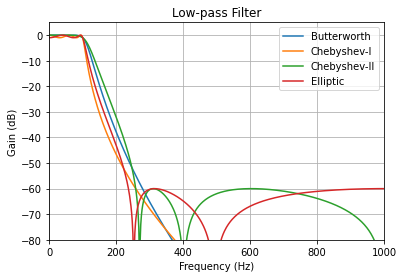

In [ ]:
system_butter = iirdesign(Fp, Fst, Ap, Ast, analog=False, ftype='butter', output='ba', fs=Fs)
w, h = freqz(*system_butter)
ax = plot_response(Fs, w, h, title="Low-pass Filter", label='Butterworth')

system_cheby1 = iirdesign(Fp, Fst, Ap, Ast, analog=False, ftype='cheby1', output='ba', fs=Fs)
w, h = freqz(*system_cheby1)
plot_response(Fs, w, h, label='Chebyshev-I', ax=ax)

system_cheby2 = iirdesign(Fp, Fst, Ap, Ast, analog=False, ftype='cheby2', output='ba', fs=Fs)
w, h = freqz(*system_cheby2)
plot_response(Fs, w, h, label='Chebyshev-II', ax=ax)

system_ellip = iirdesign(Fp, Fst, Ap, Ast, analog=False, ftype='ellip', output='ba', fs=Fs)
w, h = freqz(*system_ellip)
plot_response(Fs, w, h, label='Elliptic', ax=ax, ylim=-80)

Group Delay Comparison

With IIR filters, we need to consider not only the ripple/transition width tradeoff, but also the degree of phase distortion. We know that it is impossible to have linear-phase throughout the entire Nyquist interval. Thus we may want to see how far from linear the phase response is. A good way to do this is to look at the (ideally constant) group delay and see how flat it is.

Compare the group delay of the four IIR filters designed above.

If phase is an issue, keep in mind that Butterworth and Chebyshev Type II designs have the flattest group delay and thus introduce the least distortion.

/usr/local/lib/python3.6/dist-packages/scipy/signal/filter_design.py:685: UserWarning: The group delay is singular at frequencies [3.117, 3.123, 3.129, 3.135], setting to 0
  format(", ".join("{0:.3f}".format(ws) for ws in w[singular]))


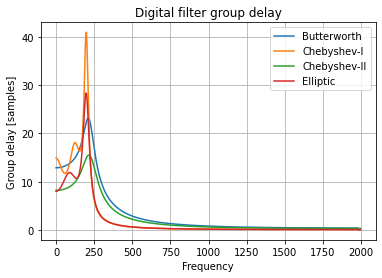

In [ ]:
w, gd_butter = group_delay(system_butter)
w, gd_cheby1 = group_delay(system_cheby1)
w, gd_cheby2 = group_delay(system_cheby2)
w, gd_ellip = group_delay(system_ellip)


plt.title('Digital filter group delay')
plt.plot(w/np.pi*Fs, gd_butter, label='Butterworth')
plt.plot(w/np.pi*Fs, gd_cheby1, label='Chebyshev-I')
plt.plot(w/np.pi*Fs, gd_cheby2, label='Chebyshev-II')
plt.plot(w/np.pi*Fs, gd_ellip, label='Elliptic')
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency')
plt.legend()
plt.grid()